In [11]:
from reservoirUtils import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(<Figure size 1200x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9eded92438>)

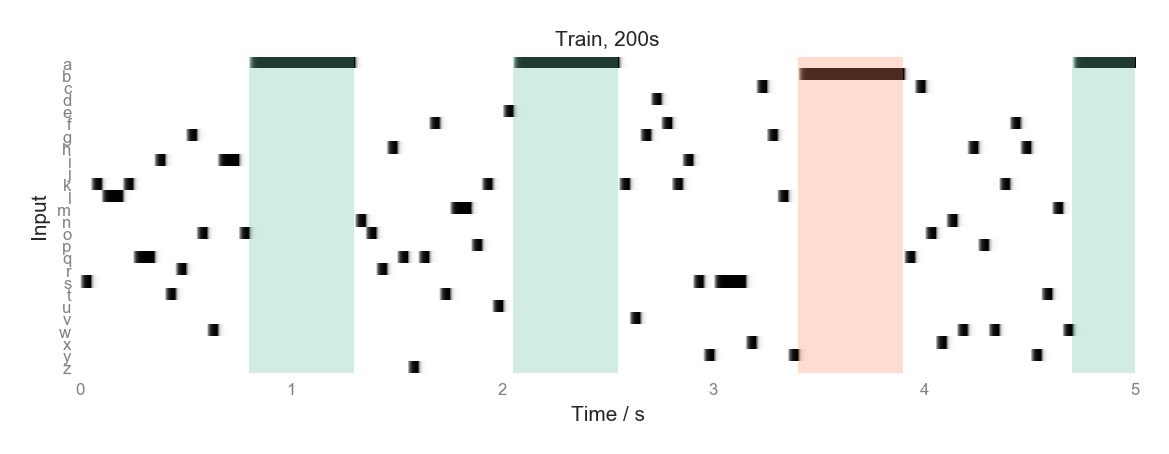

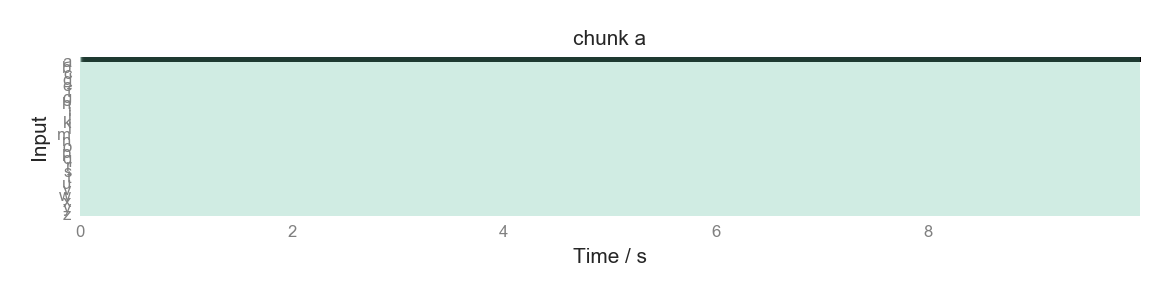

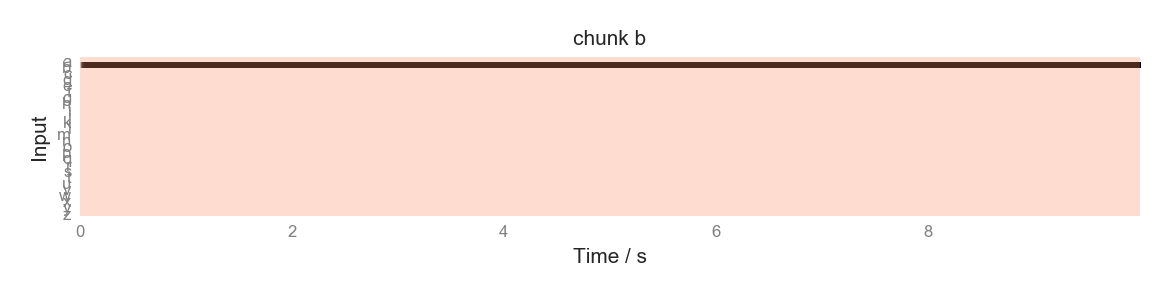

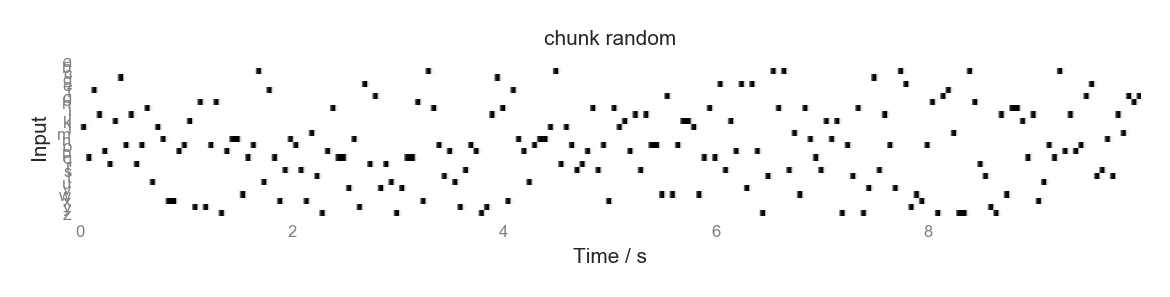

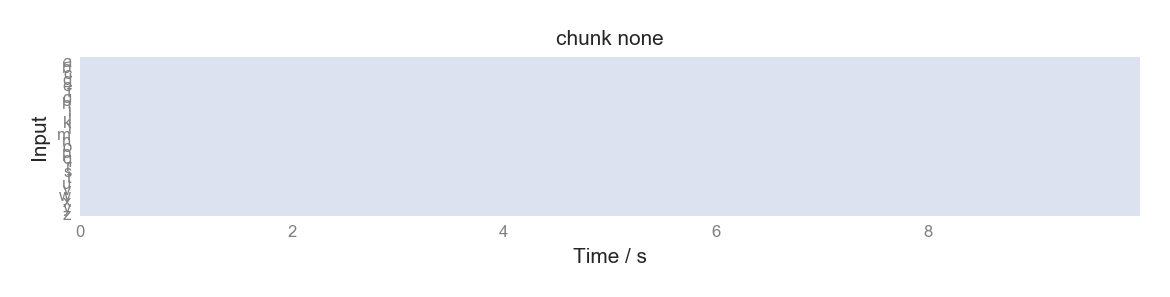

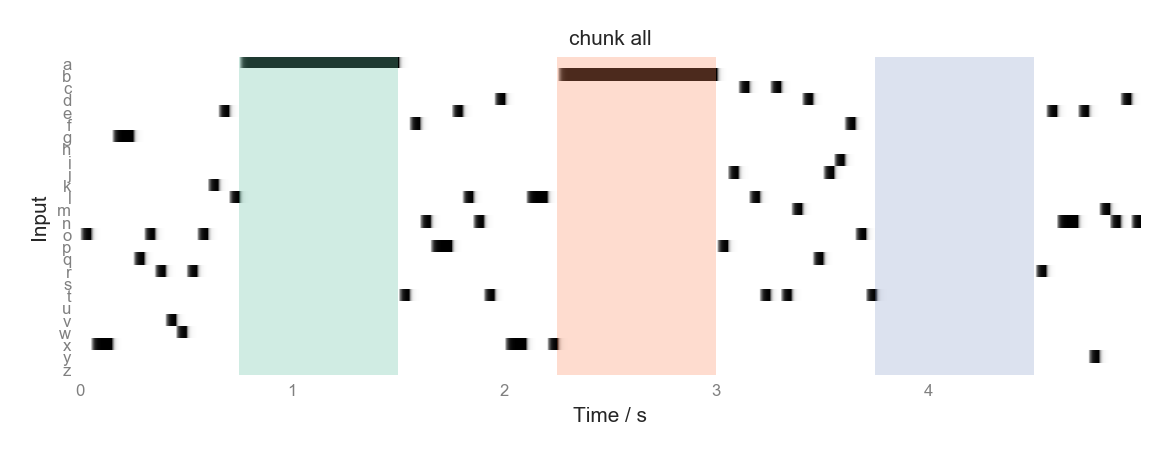

In [102]:
inputParams = defaultInputParams.copy()
inputParams['chunkList'] =[['a']*10,['b']*10]
inputParams['interChunkSyllables'] = alphabet[2:]
inputParams['gapRange'] = [15,20]
inputs = getInputs(inputParams,totalTime=200)
plotInputs(inputs,title='Train, 200s')

inputsTest = getInputs(inputParams,totalTime=5)
#plotInputs(inputsTest,title='Test, 10s')

inputParams = defaultInputParams.copy()
inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [['a']*200]
inputParams['chunkLabels'] = [0]
inputsTest_a = getInputs(inputParams)
plotInputs(inputsTest_a,title='chunk a',tstart=0,tend=10)

inputParams = defaultInputParams.copy()
inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [['b']*200]
inputParams['chunkLabels'] = [1]
inputsTest_b = getInputs(inputParams)
plotInputs(inputsTest_b,title='chunk b',tstart=0,tend=10)

inputParams = defaultInputParams.copy()
inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [['ab_']*200]
inputParams['chunkLabels'] = ['r']
inputsTest_r = getInputs(inputParams)
plotInputs(inputsTest_r,title='chunk random',tstart=0,tend=10)

inputParams = defaultInputParams.copy()
inputParams['singleChunkOnly'] = True
inputParams['chunkList'] = [[' ']*200]
inputParams['chunkLabels'] = ['2']
inputsTest_n = getInputs(inputParams)
plotInputs(inputsTest_n,title='chunk none',tstart=0,tend=10)

inputParams = defaultInputParams.copy()
inputParams['chunkList'] = [[' ']*15,['a']*15,['b']*15]
inputParams['interChunkSyllables'] = alphabet[2:]
inputParams['gapRange'] = [15,15]
inputParams['chunkLabels'] = [2,0,1]
# inputsTest_all = getInputs(inputParams,totalTime=5)
plotInputs(inputsTest_all,title='chunk all')

(<Figure size 1200x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f2e4cff28>)

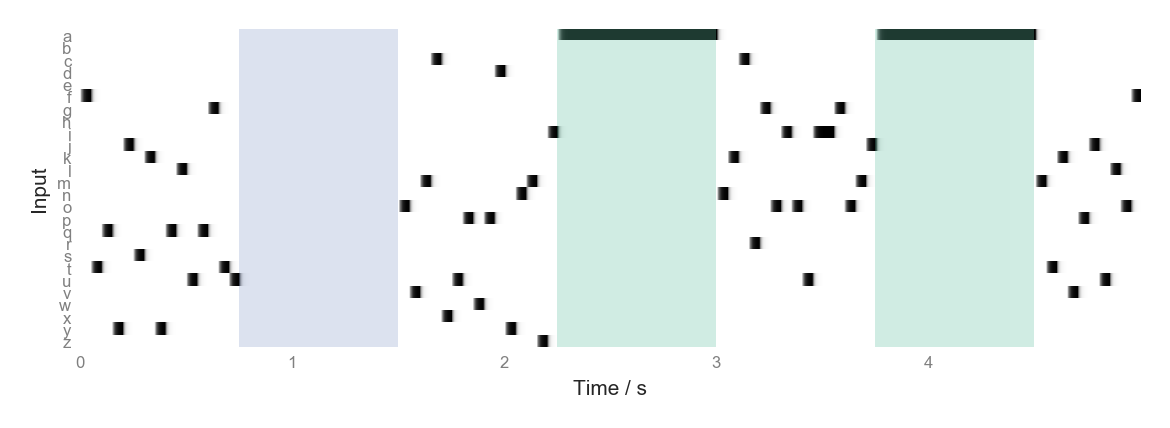

In [75]:
plotInputs(inputsTest_all)

In [115]:
hyperparams = defaultHyperparams.copy()
#hyperparams = {'Ng' : 200, #no. neurons in each reservoir 
#               'n' : 100, #no. reservoir neurons the output neuron is connected to 
##               'p' : 1, #connection probability amongst recurrent units
#               'tau' : 10, #neuron time constant, in ms 
#               'dt' : 1, #simulation timestep in ms
#               'g_GG' : 1.5, #RNN chaos parameters ( > 1 means chaos)
#               'g_Gz' : 1, #feedback strength,
#               'alpha' : 100, #learning rate
#               'sigma' : 0.3,#amount of network noise
#               'Nz' : 1, #no. of output neurons,
#               'ipr' : 3,
#               'Ni' : 26} #no. input neurons. Must be consistent with ther inputs passed 
hyperparams['Nin'] = inputs['data'].shape[1]
hyperparams['Nres'] = 300
hyperparams['p'] = 0.5
hyperparams['sigma'] = 0.1
hyperparams['g_FB'] = 2
# hyperparams['Nres_in'] = 150
# hyperparams['Nres_out'] = 150

In [116]:
#reservoirPair = ReservoirPair(hyperparams,inputs)
reservoirPair.trainPair(maxTrainTime=100)
testReservoir(reservoirPair.res1,inputs=inputsTest,testName='posttraining',Ntest=5,saveItems=['z','r'])

Training reservoir pair:   0%|          | 0/100000 [00:00<?, ?it/s]

Running multiple tests of reservoir:   0%|          | 0/5 [00:00<?, ?it/s]

Test 0:   0%|          | 0/10000 [00:00<?, ?it/s]

Test 1:   0%|          | 0/10000 [00:00<?, ?it/s]

Test 2:   0%|          | 0/10000 [00:00<?, ?it/s]

Test 3:   0%|          | 0/10000 [00:00<?, ?it/s]

Test 4:   0%|          | 0/10000 [00:00<?, ?it/s]

In [42]:
pickleAndSave(reservoirPair,'lyapunov')

In [15]:
reservoirPair = loadAndDepickle('lyapunov')

Running multiple tests of reservoir:   0%|          | 0/30 [00:00<?, ?it/s]

Test 0:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 1:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 2:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 3:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 4:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 5:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 6:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 7:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 8:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 9:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 10:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 11:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 12:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 13:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 14:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 15:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 16:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 17:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 18:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 19:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 20:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 21:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 22:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 23:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 24:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 25:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 26:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 27:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 28:   0%|          | 0/5000 [00:00<?, ?it/s]

Test 29:   0%|          | 0/5000 [00:00<?, ?it/s]

(<Figure size 1200x300 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9eea4098d0>)

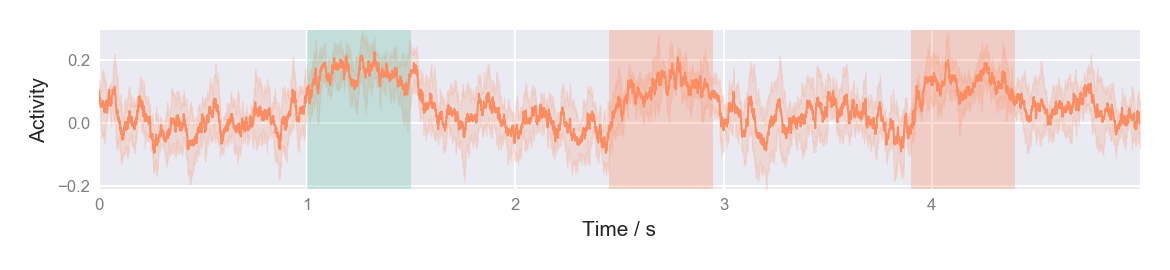

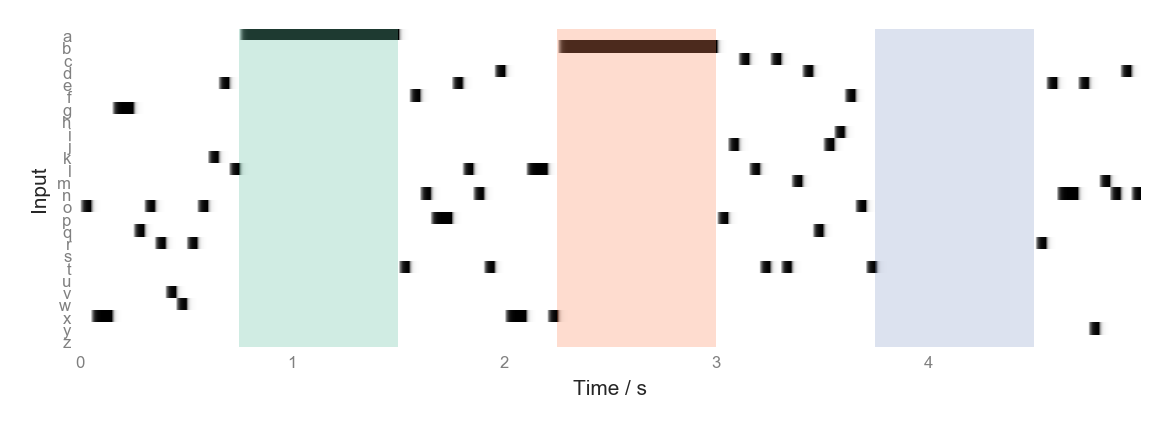

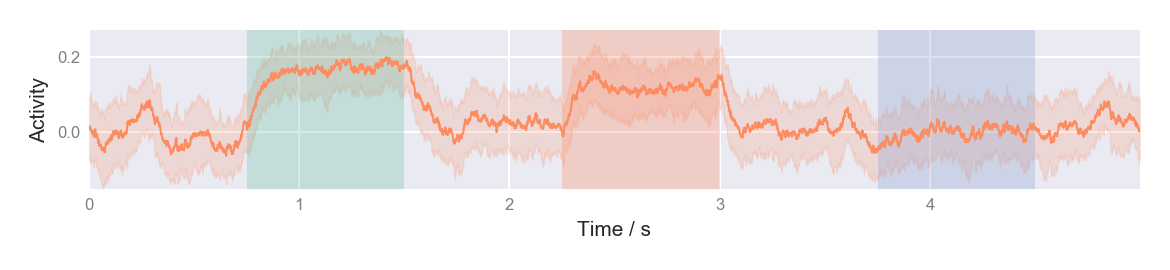

In [117]:
plotTest(reservoirPair.res1,testName='posttraining')
plotInputs(inputsTest_all)
testReservoir(reservoirPair.res1,testName='allchunks',inputs=inputsTest_all,Ntest=30)
plotTest(reservoirPair.res1,testName='allchunks')


### Find the lyapunov exponent for a standard reservoir net 

Testing different g values:   0%|          | 0/2 [00:00<?, ?it/s]

Performing 5 repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Performing 5 repeats:   0%|          | 0/5 [00:00<?, ?it/s]

Text(0, 0.5, 'Perturbation size: $\\frac{ \\Vert \\vec{\\mathbf{x}}(t) - \\vec{\\mathbf{x}}_{ref}(t) \\Vert }{ \\langle \\Vert  \\vec{\\mathbf{x}}_{ref}(0)  \\Vert \\rangle }$')

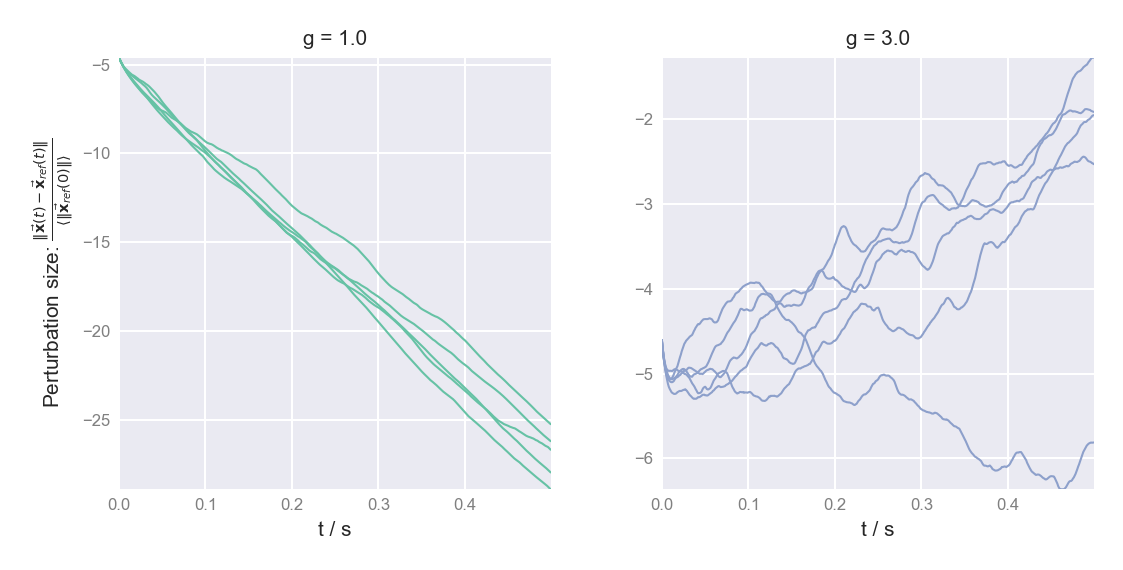

In [4]:
hyperparams = defaultHyperparams.copy()
hyperparams['sigma'] = 0.3
inputStrength = 1
noiseStrength = 1
feedbackStrength = 1

colorList = ['C0','C2','C1']

g_range = [1,3]
fig,ax = plt.subplots(1,len(g_range),figsize=(2*len(g_range),2))

steps = 500
nTests = 5
n_g = len(g_range)
t = np.arange(steps+1)*hyperparams['dt']

hyperparams['dt'] = 1
hyperparams['sigma'] *= noiseStrength

animationX = np.zeros(shape=(n_g,steps,nTests,2))
                    
for (i,g) in enumerate(tqdm(g_range,desc="Testing different g values")):
    plotDeviation = np.zeros(shape=(nTests,steps))
    np.random.seed()
    #INITIALISE REFERENSE RESERVOIR AND SPIN IT UP 
    hyperparams['g_res'] = g

    refRes = Reservoir(hyperparams)
    refRes.J_Gz *= feedbackStrength  #feedback
    refRes.J_GI *= inputStrength #inputs (uniform)

    xav = np.linalg.norm(refRes.x)
    for j in range(1000): #1 seconds spin up
        x = np.linalg.norm(refRes.runDynamicsStep(inputVec=np.ones(hyperparams['Nin']),returnItems=['x'])['x'])
        xav = xav + (1/(j+1))*(x - xav)

    copy_xs = np.zeros(shape=(len(g_range),steps,nTests,2))
    for n in tqdm(range(nTests),leave=False,desc='Performing %g repeats' %nTests):
        np.random.seed()
        refRes = Reservoir(hyperparams)
        refRes.J_Gz *= feedbackStrength  #feedback
        refRes.J_GI *= inputStrength #inputs (uniform)
        for j in range(1000): #1 seconds spin up
            refRes.runDynamicsStep(inputVec=np.ones(hyperparams['Nin']))
        copyRes = copy.deepcopy(refRes)
        perturbation = np.random.randn(refRes.Nres)
        perturbation /= np.linalg.norm(perturbation)
        perturbation *= 0.01*xav #random perturbation 10% size of x 
        copyRes.x += perturbation
        
        for s in range(steps):
            animationX[i,s,n,:] = copyRes.x[:2] - refRes.x[:2]
            plotDeviation[n,s] = np.linalg.norm(copyRes.x - refRes.x)
            np.random.seed(s)
            refRes.runDynamicsStep(inputVec=np.ones(hyperparams['Nin']))
            np.random.seed(s)
            copyRes.runDynamicsStep(inputVec=np.ones(hyperparams['Nin']))
 
        ax[i].plot(np.arange(steps)*hyperparams['dt']/1000,np.log(plotDeviation[n]/xav),c=colorList[i])
    ax[i].set_xlabel("t / s")
    ax[i].set_title("g = %.1f" %g)
    ax[i].set_aspect((ax[i].get_xlim()[1]-ax[i].get_xlim()[0])/(ax[i].get_ylim()[1]-ax[i].get_ylim()[0]))
        
ax[0].set_ylabel(r"Perturbation size: $\frac{ \Vert \vec{\mathbf{x}}(t) - \vec{\mathbf{x}}_{ref}(t) \Vert }{ \langle \Vert  \vec{\mathbf{x}}_{ref}(0)  \Vert \rangle }$")    

In [76]:
saveFigure(fig,"chaosdeviation")

In [7]:
i = 2
fps = 10
length = 15 #s
writer = anim.FFMpegWriter(fps=fps,bitrate=4000) 
a = AnimatedChaos(data=animationX[i],fps=fps,length=length,xylim=5,color=colorList[i])
a.ani.save('./figures/chaosg20.mp4', writer=writer,dpi=300)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [23]:
Video("./figures/chaosg20.mp4")

## Test variance over a chunk boundary

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 5000, 300)


(<Figure size 1200x600 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f2fe70710>)

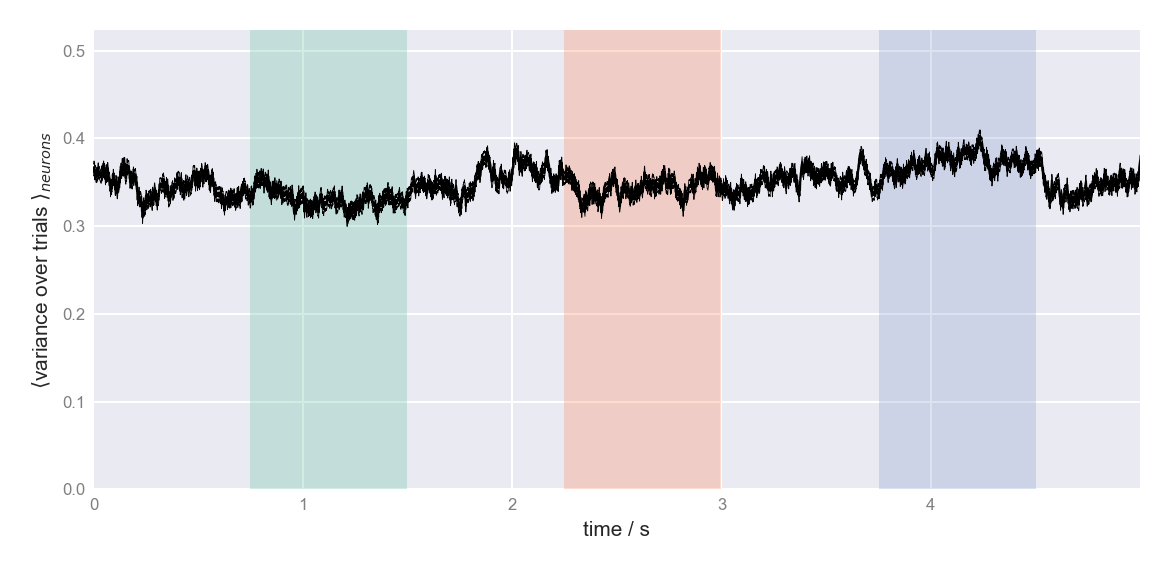

In [114]:
def testVarianceOverChunk(reservoir,chunk,ntest=10):
    nodeData = np.zeros(shape=(ntest,chunk['data'].shape[0],reservoir.Nres))
    for n in tqdm(range(ntest)):
        for t in range(chunk['data'].shape[0]):
            nodeData[n,t,:] = reservoir.runDynamicsStep(inputVec=chunk['data'][t],returnItems=['r'])['r']
    print(nodeData.shape)
    varOverTrials = np.var(nodeData,axis=0)
    meanOverTrials = np.abs(np.mean(nodeData,axis=0))
    
    meanOfVar = np.mean(varOverTrials,axis=1)
    stdOfVar = np.std(varOverTrials,axis=1)
    semOfVar = stdOfVar / np.sqrt(nodeData.shape[2])
    meanOfMean = np.mean(meanOverTrials,axis=1)
    stdOfMean = np.std(meanOverTrials,axis=1)
    semOfMean = stdOfMean / np.sqrt(nodeData.shape[2])

    
    chunkData = chunk['chunkData']
    colors = chunk['chunkLabelList'].copy()
    for i in range(len(colors)):
        if colors[i] == 'r': colors[i] = 'lightgrey'
        else: 
            colors[i] = 'C' + str(colors[i])


    fig, ax = plt.subplots(figsize=(4,2))

    # ax[1].plot(chunk['t'],meanOfVar,color=colors, s=0.5)

    ax.plot(chunk['t'],meanOfVar,color='k',linewidth=0.5)
    ax.plot(chunk['t'],meanOfVar+semOfVar,c='k',linewidth=0.2)
    ax.plot(chunk['t'],meanOfVar-semOfVar,c='k',linewidth=0.2)
    ax.set_ylabel(r"$\langle$variance over trials $\rangle_{neurons}$")
    ax.set_xlabel("time / s")
    ax.set_ylim(bottom=0,top=max(meanOfVar+stdOfVar))

    for c in chunkData:
	    rect = matplotlib.patches.Rectangle((c[1],3),(c[2]-c[1]),-6,linewidth=0,edgecolor='r',facecolor='C%s'%(c[0]),alpha=0.3)
	    ax.add_patch(rect)

    saveFigure(fig, "variance")

    return fig, ax




testVarianceOverChunk(reservoirPair.res1,inputsTest_all)



        
        

In [ ]:
## Test Lyapunov component in chunk

In [119]:
def getLyapunovExponent(reservoir, chunk, tstart, ncopies=10, tperturbation=1,color='C0'):
    reservoir = copy.deepcopy(reservoir)
    reservoir.sigma = 0.01
    startPertId = np.argmin(np.abs(chunk['t'] - tstart))
    stopPertId = np.argmin(np.abs(chunk['t'] - (chunk['t'][startPertId] + tperturbation)))
    tPerturbation = chunk['t'][startPertId:stopPertId]

    #spin up 
    fig, ax = plt.subplots(figsize=(2,2))

    for n in tqdm(range(ncopies)):
        np.random.seed(n)
        copyreservoir = copy.deepcopy(reservoir)
        xav = 0
        for t_id in range(startPertId): #spin up 
            x = copyreservoir.runDynamicsStep(inputVec=chunk['data'][t_id],returnItems=['x'])['x']
            xav = xav + (1/(t_id+1))*(np.linalg.norm(x) - xav)
        #make copies
        pert_res = copy.deepcopy(copyreservoir) #reservoir to be perturbed 
        ref_res = copy.deepcopy(copyreservoir) #reference reservoir 
        #perturb one of them
        # perturbation = np.random.randn(ref_res.Nres)
        # perturbation /= np.linalg.norm(perturbation)
        # perturbation *= 0.1*xav #random perturbation 10% size of x 
        perturbation = np.sqrt(reservoir.dt)*reservoir.sigma*np.random.randn(reservoir.Nres)
        pert_res.x += perturbation
        
        x_pert_0, x_pert = pert_res.x, pert_res.x
        x_ref_0, x_ref = ref_res.x, ref_res.x
        pert_size = np.linalg.norm(x_ref - x_pert) / np.linalg.norm(x_ref_0 - x_pert_0)
        #run dynamics
        pert_size_array = []
        z_array = []
        for t_id in range(startPertId,stopPertId):
            pert_size_array.append(pert_size)
            z_array.append(ref_res.z)
            np.random.seed(t_id)
            x_ref = ref_res.runDynamicsStep(inputVec = chunk['data'][t_id], returnItems=['x'])['x']
            np.random.seed(t_id)
            x_pert = pert_res.runDynamicsStep(inputVec = chunk['data'][t_id], returnItems=['x'])['x']
            pert_size = np.linalg.norm(x_ref - x_pert)/np.linalg.norm(x_ref_0 - x_pert_0)
        ax.plot(tPerturbation,pert_size_array,c=color)
        ax.set_yscale('log')
        # ax.plot(tPerturbation,z_array,c=color)
        ax.set_xlabel("Time")
        ax.set_ylabel("Perturbation size")

        saveFigure(fig,str(color))

    return 

ncopies = 2
tperturbation = 2
getLyapunovExponent(reservoirPair.res1,inputsTest_r,tstart=1,tperturbation=tperturbation,ncopies=ncopies,color='lightgrey')
getLyapunovExponent(reservoirPair.res1,inputsTest_n,tstart=1,tperturbation=tperturbation,ncopies=ncopies,color='C2')
getLyapunovExponent(reservoirPair.res1,inputsTest_a,tstart=1,tperturbation=tperturbation,ncopies=ncopies,color='C0')
getLyapunovExponent(reservoirPair.res1,inputsTest_b,tstart=1,tperturbation=tperturbation,ncopies=ncopies,color='C1')

SyntaxError: invalid syntax (<ipython-input-119-1d47a868694a>, line 25)